In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA
import pypfopt
from scipy.stats import t
from pypfopt import expected_returns
from pypfopt import risk_models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN,Flatten

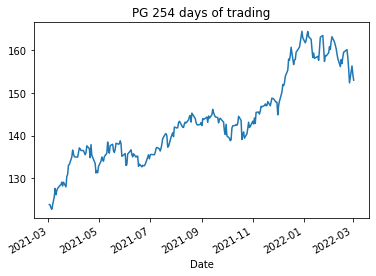

In [15]:
df=pd.read_csv('PG_5YR.csv',parse_dates=['Date'],index_col=0)
df=df.sort_index().tail(254)

df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna()

df['Open'].plot()
plt.title("PG 254 days of trading")
plt.show()

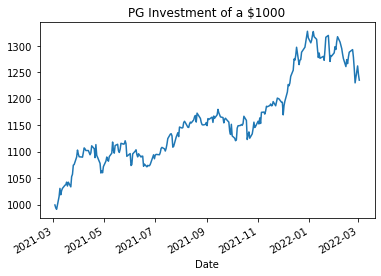

In [16]:
def return_calculate(df,investment,title):
    df_returns=df['Open'].pct_change()
    df_returns_plus_one = df_returns.add(1)
    df_cumulative_return = df_returns_plus_one.cumprod()
    df_cumulative_return.mul(investment).plot()
    plt.title(title)
    plt.show()
    
return_calculate(df,1000,"PG Investment of a $1000")

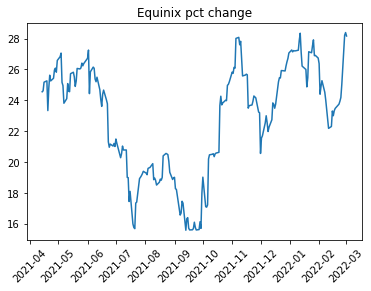

0.028526823243902974
CVaR is the expected value of loss given a minimum loss threshold.


In [20]:
returns=df['Open'].pct_change()
returns =returns.dropna()
mu = returns.rolling(30).mean()
sigma = returns.rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i,s in enumerate(sigma)]

# Compute the 99% VaR array using the rolling window parameters
VaR_99 = np.array( [ t.ppf(0.99, *params) 
                    for params in rolling_parameters ] )

plt.plot(returns.index, 0.01 * VaR_99 * 100000)
plt.xticks(rotation=45)
plt.title('Equinix pct change')
plt.show()

p = t.fit(returns)
VaR_99 = t.ppf(0.99, *p)
# Use the fitted parameters and VaR_99 to compute CVaR_99
tail_loss = t.expect(lambda y: y, args = (p[0],), loc = p[1], scale = p[2], lb = VaR_99 )
CVaR_99 = (1 / (1 - 0.99)) * tail_loss
print(CVaR_99)
print("CVaR is the expected value of loss given a minimum loss threshold.")

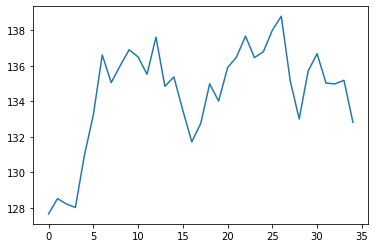

In [79]:
def convertToMatrix(data,step,sequence_size):
    X=[]
    y=[]
 
    for i in range(0, len(data) - sequence_size, step):
        X.append(data[i:i+sequence_size])
        #print("X",X)
        y.append(data[i+sequence_size])
        #print(y)
    return np.array(X),np.array(y)

N=len(df)
tp=int(N*.3)

#print(N,tp)

values=df['Open'].values.reshape(-1,1)
#print(values)
train,test=values[0:tp,:],values[tp:N,:]

step=2
test=np.append(test,np.repeat(test[-1,:],step))
train=np.append(train,np.repeat(train[-1,:],step))

sequence_size=8
X_train,y_train=convertToMatrix(train,step,sequence_size)
X_test,y_test=convertToMatrix(test,step,sequence_size)

scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))


t=np.linspace(0,len(y_train))

plt.plot(y_train)

3/3 [==============================] - 0s 3ms/step - loss: 1842.1320 - accuracy: 0.0000e+00
Accuracy [1842.1319580078125, 0.0]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 320)               105280    
                                                                 
 dense_30 (Dense)            (None, 800)               256800    
                                                                 
 dense_31 (Dense)            (None, 1)                 801       
                                                                 
Total params: 362,881
Trainable params: 362,881
Non-trainable params: 0
_________________________________________________________________


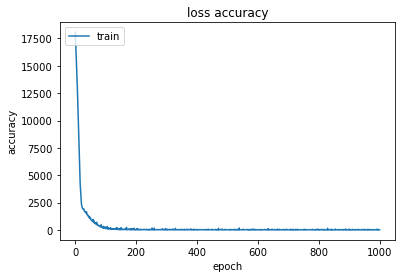

In [86]:
model=Sequential()
model.add(SimpleRNN(units=320, input_shape=(1,sequence_size), activation='LeakyReLU'))
model.add(Dense(800, activation='LeakyReLU')) 
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

history=model.fit(X_train,y_train, epochs=1000, verbose=0)

print("Accuracy",model.evaluate(X_test,y_test))

model.summary()

plt.plot(history.history['loss'])
plt.title('loss accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

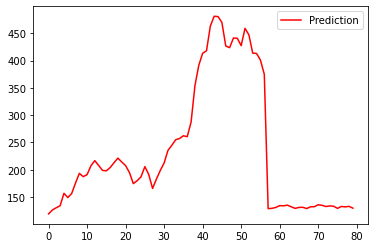

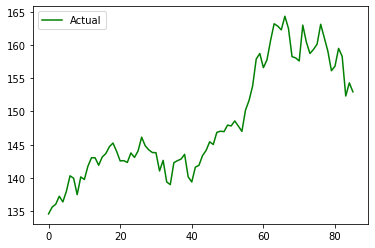

In [88]:
test_prediction = model.predict(X_test)
#train_prediction=model.predict(X_train)
#prediction=np.concatenate((test_prediction,train_prediction),axis=0)

plt.plot(prediction,label="Prediction",c='red')
plt.legend()
plt.show()
#plt.plot(np.concatenate((y_train,y_test),axis=0),label="Actual",c='green')
plt.plot(y_test,label="Actual",c='green')
plt.legend()
plt.show()

VaR_95:  0.015966213173871945 ; Backtest:  0.05138339920948617


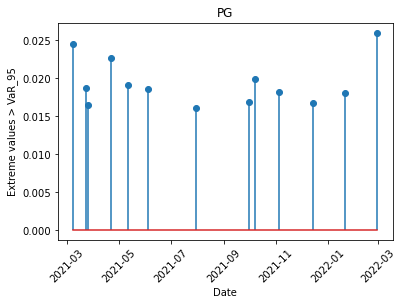

In [90]:
VaR_95 = np.quantile(returns, 0.95)

extreme_values = returns[returns > VaR_95]
print("VaR_95: ", VaR_95, "; Backtest: ", len(extreme_values) / len(returns) )

plt.stem(extreme_values.index, extreme_values.values)
plt.ylabel("Extreme values > VaR_95"); plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title('PG')
plt.show()

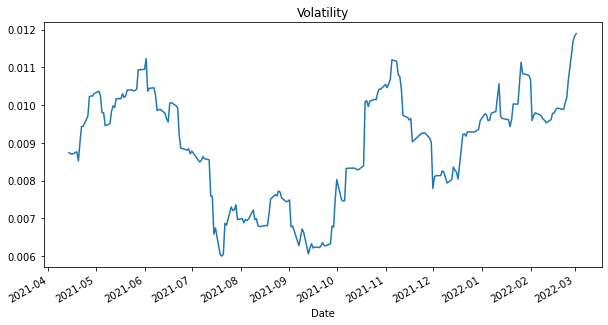

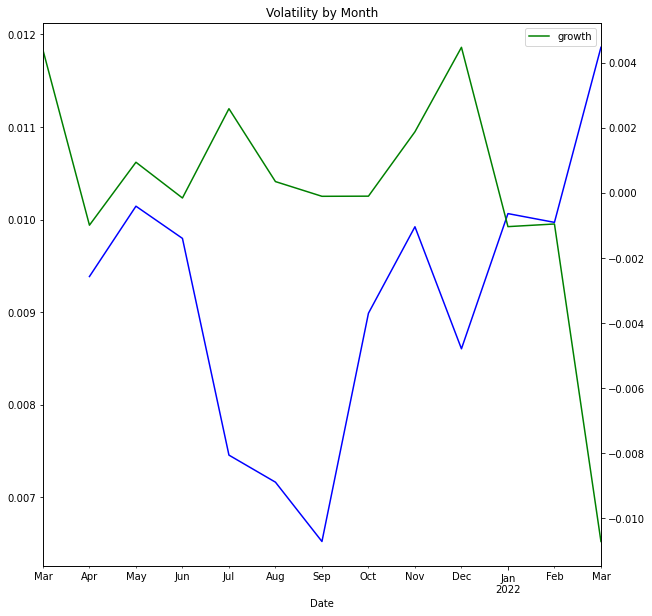

volatility is good if growth pct change is generally positive


In [103]:
fig,ax = plt.subplots(figsize=(10,5))
rolling=returns.rolling(30)
volatility=rolling.std().dropna()
volatility.plot(ax=ax)
plt.title("Volatility")
plt.show()


vol_mean=volatility.resample('M').mean()
growth=returns.resample('M').mean()

fig,ax = plt.subplots(figsize=(10,10))
vol_mean.plot(label="volatility",ax=ax,c='b')
twin_ax=ax.twinx()
growth.plot(label="growth",ax=twin_ax,c='g')
plt.title('Volatility by Month')
plt.legend()
plt.show()
#print(vol_mean)

print("volatility is good if growth pct change is generally positive")